<a href="https://colab.research.google.com/github/yr2387/E4511-2021-Rong/blob/main/SLC6A2_EDA_students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory data analysis
In this notebook we will analyze assay measurements and molecules for datasets from Chembl, DTC and Excape.
1. ***COPY*** this notebook into your own google drive. Work and edit from that one
2. For homework, you will work on this entire notebook for your own targets. Download your target related data from the following databases:
  - https://www.ebi.ac.uk/chembl/
  - https://drugtargetcommons.fimm.fi/
  - https://solr.ideaconsult.net/search/excape/

## Install packages

In [2]:
%tensorflow_version 1.x

# get the Anaconda file 
! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! chmod +x Anaconda3-2019.10-Linux-x86_64.sh
! bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local

! time conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc

# install mordred, bravado and molvs
! time conda install -c conda-forge -y mordred bravado molvs

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

TensorFlow 1.x selected.
--2021-03-18 20:14:43--  https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 530308481 (506M) [application/x-sh]
Saving to: ‘Anaconda3-2019.10-Linux-x86_64.sh’

Anaconda3-2019.10-L 100%[===================>] 505.74M   183MB/s    in 2.8s    

2021-03-18 20:14:45 (183 MB/s) - ‘Anaconda3-2019.10-Linux-x86_64.sh’ saved [530308481/530308481]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _ipyw_jlab_nb_ext_conf==0.1.0=py37_0
    - _libgcc_mutex==0.1=main
    - alabaster==0.7.12=py37_0
    - anaconda-client==1.7.2=py37_0
    - anaconda-navigator==1.9.7

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - bravado
    - molvs
    - mordred


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bravado-11.0.3             |     pyhd8ed1ab_0          31 KB  conda-forge
    bravado-core-5.17.0        |     pyh9f0ad1d_0          48 KB  conda-forge
  

In [4]:
# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')

import json
import requests
import io

In [67]:
# Import AMPL libraries
# 
import atomsci.ddm.utils.data_curation_functions as dcf
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.pipeline.diversity_plots as dp
import atomsci.ddm.pipeline.chem_diversity as cd
# Additional python libraries
import pandas as pd
import numpy as np
import getpass, os
import seaborn as sns

## Download/Load data

In [6]:
! wget https://raw.githubusercontent.com/yr2387/E4511-2021-Rong/main/Data/ChEMBL_SLC6A2.csv
! wget https://raw.githubusercontent.com/yr2387/E4511-2021-Rong/main/Data/DTC_SLC6A2.csv
! wget https://raw.githubusercontent.com/yr2387/E4511-2021-Rong/main/Data/ExCAPE_SLC6A2.csv

--2021-03-18 20:25:11--  https://raw.githubusercontent.com/yr2387/E4511-2021-Rong/main/Data/ChEMBL_SLC6A2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3696027 (3.5M) [text/plain]
Saving to: ‘ChEMBL_SLC6A2.csv’

ChEMBL_SLC6A2.csv   100%[===================>]   3.52M  --.-KB/s    in 0.05s   

2021-03-18 20:25:12 (71.9 MB/s) - ‘ChEMBL_SLC6A2.csv’ saved [3696027/3696027]

--2021-03-18 20:25:12--  https://raw.githubusercontent.com/yr2387/E4511-2021-Rong/main/Data/DTC_SLC6A2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383

In [7]:
dtc = pd.read_csv("DTC_SLC6A2.csv", sep=',', header=0 )
excape = pd.read_csv("ExCAPE_SLC6A2.csv", sep=',', header=0)
chembl = pd.read_csv("ChEMBL_SLC6A2.csv", sep=',', header=0 )

In [8]:
dtc.iloc[1:3,1:10]

,Uniprot ID,Compound Name,Standard inchi key,Max Phase,Target Pref Name,Gene Names,Target Class,Wild type or mutant,Mutation information
1,P23975,SB-203580,CDMGBJANTYXAIV-UHFFFAOYSA-N,0,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN
2,P23975,AMIFOSTINE,JKOQGQFVAUAYPM-UHFFFAOYSA-N,4,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN


In [9]:
excape.iloc[1:3, 1:15]

,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES
1,16494915,6530,A,5.00056,pubchem,578387,9606,SLC6A2,4059,S1C(C2(CCCCC2)CN)=CC=C1
2,CHEMBL195437,6530,N,4.21000,chembl20,774705,9606,SLC6A2,4059,C=1(C=CC(=CC1)CCCCCCCC)O


In [10]:
chembl.iloc[1:3, 1:10]

,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation
1,NaN,0,394.95,1,5.47,30,Clc1cccc(N2CCN(CCCCOc3ccc4ccccc4c3)CC2)c1,Inhibition,'='
2,NaN,0,262.36,0,3.75,BDBM170456,CN1Cc2ccccc2C(c2ccc3cc[nH]c3c2)C1,Ki,'='


# Examine data
- What molecular (and other) identifiers exist for compounds from each database?
- What assay response types are there in each file?
- Think about how we might combine these data sources together

In [11]:
chembl.columns = chembl.columns.str.replace(' ','_') # get rid of annoying spaces
dtc.columns = dtc.columns.str.replace(' ','_') # get rid of annoying spaces
excape.columns = excape.columns.str.replace(' ','_') # get rid of annoying spaces


print(chembl.shape)
print(dtc.shape)
print(excape.shape)

(7603, 45)
(6998, 43)
(2776, 11)


In [12]:
chembl.head()

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties
0,CHEMBL3310477,NaN,0,358.21,1,5,2ak,Fc1ccc(OC(CC2CNC2)c2ccc(Cl)c(Cl)c2)cc1F,Inhibition,'=',100.0,%,NaN,NaN,NaN,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL3364219,Inhibition of norepinephrine reuptake at human...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL222,Norepinephrine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL3352322,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2014.0,CHEMBL3307715,NaN
1,CHEMBL4294989,NaN,0,394.95,1,5.47,30,Clc1cccc(N2CCN(CCCCOc3ccc4ccccc4c3)CC2)c1,Inhibition,'=',63.7,%,NaN,NaN,NaN,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL4276209,Inhibition of [3H]norepinephrine uptake at hum...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL222,Norepinephrine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL4270660,1,Scientific Literature,Bioorg Med Chem,2018.0,None,NaN
2,CHEMBL3323102,NaN,0,262.36,0,3.75,BDBM170456,CN1Cc2ccccc2C(c2ccc3cc[nH]c3c2)C1,Ki,'=',6.7,nM,8.17,NaN,314424,UO_0000065,31.16,0.56,4.42,42.95,False,CHEMBL3705836,Binding Assay: In order to evaluate the relati...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293E,None,NaN,NaN,NaN,CHEMBL222,Norepinephrine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL3638841,37,BindingDB Database,NaN,2015.0,None,NaN
3,CHEMBL3310035,NaN,0,278.26,0,1.62,4,COC(=O)CCc1cc2cc(C)oc(=O)c2c(O)c1O,Activity,NaN,NaN,NaN,NaN,NaN,Not Active,NaN,NaN,NaN,NaN,NaN,False,CHEMBL3365809,Displacement of [3H]nisoxetine from NET (unkno...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL222,Norepinephrine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL3352407,1,Scientific Literature,J. Nat. Prod.,2014.0,CHEMBL3307715,NaN
4,CHEMBL598346,NaN,0,289.32,0,4.22,1,Fc1ccccc1Oc1cccc(F)c1C1CCNCC1,EC50,'=',28.0,nM,7.55,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL1645860,Agonist activity at human cloned NET expressed...,F,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL222,Norepinephrine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1641456,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2011.0,CHEMBL3307715,NaN


In [13]:
chembl.Standard_Type.value_counts()

IC50                                                   3350
Ki                                                     2949
Inhibition                                              870
Activity                                                217
EC50                                                     51
Ratio                                                    40
Kd                                                       28
FC                                                       24
INH                                                      14
Ratio IC50                                               14
% Ctrl                                                    9
% Inhibition of Control Specific Binding (Mean n=2)       8
Km                                                        6
Vmax                                                      6
Bmax                                                      6
Drug uptake                                               6
Efficacy                                

## Exercise: Explore datasets
- explore the loaded dtc and excape dataframes
- answer the following questions

## Questions

Number of data points in each file:

Molecular identifiers from each file:

Data types from each file:

Data units in each file:

What is the formula to translate IC50 to pIC50?

What other information might be useful?

In [14]:
# You code goes in here and the following chunks

In [15]:
dtc.head()

,Compound_ID,Uniprot_ID,Compound_Name,Standard_inchi_key,Max_Phase,Target_Pref_Name,Gene_Names,Target_Class,Wild_type_or_mutant,Mutation_information,PubMed_ID,End_Point_Standard_Type,End_Point_Standard_Relation,End_Point_Standard_Value,End_Point_Standard_Units,Endpoint_Mode_of_Action,Assay_Format,Assay_Type,Assay_Sub_Type,Inhibitor_Type,Detection_Technology,Compound_concentration_value,Compound_concentration_value_units,Substrate_type,Substrate_Type_Standard_Relation,Substrate_Type_Standard_Value,Substrate_Type_Standard_Units,Assay_cell_line,Assay_Description,Activity_Comments,Title,Journal,Year,Volume,Issue,Authors,Annotation_Comments,Assay_ID,DTC_Tid,DTC_Activity_ID,DTC_Molregno,Record_ID,DTC_Document_ID
0,CHEMBL10,P23975,SB-203580,CDMGBJANTYXAIV-UHFFFAOYSA-N,0,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDCK,DRUGMATRIX: Norepinephrine Transporter radioli...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774705.0,DTCT0023180,7482013,DTCC00132413,2089752,46191
1,CHEMBL10,P23975,SB-203580,CDMGBJANTYXAIV-UHFFFAOYSA-N,0,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,NaN,KI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDCK,DRUGMATRIX: Norepinephrine Transporter radioli...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774705.0,DTCT0023180,7482014,DTCC00132413,2089752,46191
2,CHEMBL1006,P23975,AMIFOSTINE,JKOQGQFVAUAYPM-UHFFFAOYSA-N,4,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDCK,DRUGMATRIX: Norepinephrine Transporter radioli...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774705.0,DTCT0023180,7290025,DTCC00224760,898282,46191
3,CHEMBL1006,P23975,AMIFOSTINE,JKOQGQFVAUAYPM-UHFFFAOYSA-N,4,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,NaN,KI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDCK,DRUGMATRIX: Norepinephrine Transporter radioli...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774705.0,DTCT0023180,7290026,DTCC00224760,898282,46191
4,CHEMBL1009,P23975,LEVODOPA,WTDRDQBEARUVNC-LURJTMIESA-N,4,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDCK,DRUGMATRIX: Norepinephrine Transporter radioli...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774705.0,DTCT0023180,7423055,DTCC00224903,1351112,46191


In [16]:
dtc.End_Point_Standard_Type.value_counts()

KI              3110
IC50            3028
INHIBITION       589
ACTIVITY         128
RATIO             40
FC                24
KD                22
EC50              16
RATIO IC50        14
INH               14
DRUG UPTAKE        4
LOGEC50            2
EFFICACY           2
BMAX               1
AFFINITY           1
% INHIBITION       1
VMAX               1
KM                 1
Name: End_Point_Standard_Type, dtype: int64

In [17]:
excape.head()

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES
0,CTETYYAZBPJBHE-UHFFFAOYNA-N,CHEMBL1289,6530,A,5.56000,chembl20,774705,9606,SLC6A2,4059,C(#CI)COC=1C=C(Cl)C(=CC1Cl)Cl
1,QVLGCILLMAUJBI-UHFFFAOYNA-N,16494915,6530,A,5.00056,pubchem,578387,9606,SLC6A2,4059,S1C(C2(CCCCC2)CN)=CC=C1
2,NTDQQZYCCIDJRK-UHFFFAOYNA-N,CHEMBL195437,6530,N,4.21000,chembl20,774705,9606,SLC6A2,4059,C=1(C=CC(=CC1)CCCCCCCC)O
3,OLBCVFGFOZPWHH-UHFFFAOYNA-N,CHEMBL526,6530,A,5.03000,chembl20,774705,9606,SLC6A2,4059,OC=1C(=CC=CC1C(C)C)C(C)C
4,NGBBVGZWCFBOGO-UHFFFAOYNA-N,CHEMBL6731,6530,A,6.58000,chembl20,639476,9606,SLC6A2,4059,O1C2=C(OC1)C=CC(=C2)CC(N)C


In [18]:
excape.Activity_Flag.unique()

array(['A', 'N'], dtype=object)

# EDA: assay data responses questions
- What type of variable are the data responses?
- What kind of ML model would you build to predict this data?
- What kind of visualizations & analysis can you use to understand more about the data?

In [19]:
chembl.head()

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties
0,CHEMBL3310477,NaN,0,358.21,1,5,2ak,Fc1ccc(OC(CC2CNC2)c2ccc(Cl)c(Cl)c2)cc1F,Inhibition,'=',100.0,%,NaN,NaN,NaN,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL3364219,Inhibition of norepinephrine reuptake at human...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL222,Norepinephrine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL3352322,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2014.0,CHEMBL3307715,NaN
1,CHEMBL4294989,NaN,0,394.95,1,5.47,30,Clc1cccc(N2CCN(CCCCOc3ccc4ccccc4c3)CC2)c1,Inhibition,'=',63.7,%,NaN,NaN,NaN,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL4276209,Inhibition of [3H]norepinephrine uptake at hum...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL222,Norepinephrine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL4270660,1,Scientific Literature,Bioorg Med Chem,2018.0,None,NaN
2,CHEMBL3323102,NaN,0,262.36,0,3.75,BDBM170456,CN1Cc2ccccc2C(c2ccc3cc[nH]c3c2)C1,Ki,'=',6.7,nM,8.17,NaN,314424,UO_0000065,31.16,0.56,4.42,42.95,False,CHEMBL3705836,Binding Assay: In order to evaluate the relati...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293E,None,NaN,NaN,NaN,CHEMBL222,Norepinephrine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL3638841,37,BindingDB Database,NaN,2015.0,None,NaN
3,CHEMBL3310035,NaN,0,278.26,0,1.62,4,COC(=O)CCc1cc2cc(C)oc(=O)c2c(O)c1O,Activity,NaN,NaN,NaN,NaN,NaN,Not Active,NaN,NaN,NaN,NaN,NaN,False,CHEMBL3365809,Displacement of [3H]nisoxetine from NET (unkno...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL222,Norepinephrine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL3352407,1,Scientific Literature,J. Nat. Prod.,2014.0,CHEMBL3307715,NaN
4,CHEMBL598346,NaN,0,289.32,0,4.22,1,Fc1ccccc1Oc1cccc(F)c1C1CCNCC1,EC50,'=',28.0,nM,7.55,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL1645860,Agonist activity at human cloned NET expressed...,F,BAO_0000219,cell-based format,Homo sapiens,None,None,HEK293,None,NaN,NaN,NaN,CHEMBL222,Norepinephrine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1641456,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2011.0,CHEMBL3307715,NaN


In [20]:
chembl.Standard_Units.unique()

array(['%', 'nM', nan, 'pmol/min', 'pmol', 'uM', 'mBq', 'ug.mL-1'],
      dtype=object)

## **Curation step**: change units to be the same for all responses

In [21]:
# change uM to nM units so they're all the same
chembl['Standard_Value_nM'] = np.where(chembl.Standard_Units == 'uM',
                                           chembl.Standard_Value * 1000,
                                           chembl.Standard_Value)

## EDA: Summarize, describe, plot data for analysis

In [22]:
# summary statistics
chembl.describe()

,Molecule_Max_Phase,Standard_Value,pChEMBL_Value,Ligand_Efficiency_BEI,Source_ID,Document_Year,Standard_Value_nM
count,7603.000000,5.716000e+03,4226.000000,4077.000000,7603.000000,5680.000000,5.716000e+03
mean,0.878601,2.105396e+04,6.783202,21.690047,6.398658,2009.830986,2.120091e+04
std,1.634722,3.368720e+05,1.122663,5.704044,10.763186,4.452954,3.368791e+05
min,0.000000,-6.700000e+01,4.010000,3.110000,1.000000,1993.000000,-6.700000e+01
25%,0.000000,2.136000e+01,5.890000,17.890000,1.000000,2007.000000,2.169500e+01
50%,0.000000,1.000000e+02,6.750000,21.890000,1.000000,2009.000000,1.000000e+02
75%,0.000000,1.300750e+03,7.640000,25.450000,15.000000,2013.000000,1.350000e+03
max,4.000000,1.000000e+07,10.430000,60.270000,54.000000,2020.000000,1.000000e+07


In [23]:
chembl.describe()

,Molecule_Max_Phase,Standard_Value,pChEMBL_Value,Ligand_Efficiency_BEI,Source_ID,Document_Year,Standard_Value_nM
count,7603.000000,5.716000e+03,4226.000000,4077.000000,7603.000000,5680.000000,5.716000e+03
mean,0.878601,2.105396e+04,6.783202,21.690047,6.398658,2009.830986,2.120091e+04
std,1.634722,3.368720e+05,1.122663,5.704044,10.763186,4.452954,3.368791e+05
min,0.000000,-6.700000e+01,4.010000,3.110000,1.000000,1993.000000,-6.700000e+01
25%,0.000000,2.136000e+01,5.890000,17.890000,1.000000,2007.000000,2.169500e+01
50%,0.000000,1.000000e+02,6.750000,21.890000,1.000000,2009.000000,1.000000e+02
75%,0.000000,1.300750e+03,7.640000,25.450000,15.000000,2013.000000,1.350000e+03
max,4.000000,1.000000e+07,10.430000,60.270000,54.000000,2020.000000,1.000000e+07



Why do some columns seem numeric but not give mean, SD? Examine chembl csv file - answer is some 'None' entries

In [24]:
chembl=chembl.replace('None',np.nan)

In [25]:
# even after removing None you have to recast the column as numeric
numeric_cols=['Molecule_Max_Phase',
       'Molecular_Weight', '#RO5_Violations', 'AlogP', 'Standard_Value_nM',
       'pChEMBL_Value', 'Ligand_Efficiency_BEI', 'Ligand_Efficiency_LE',
       'Ligand_Efficiency_LLE', 'Ligand_Efficiency_SEI']
for col in numeric_cols:
  chembl[col]=chembl[col].astype(float)

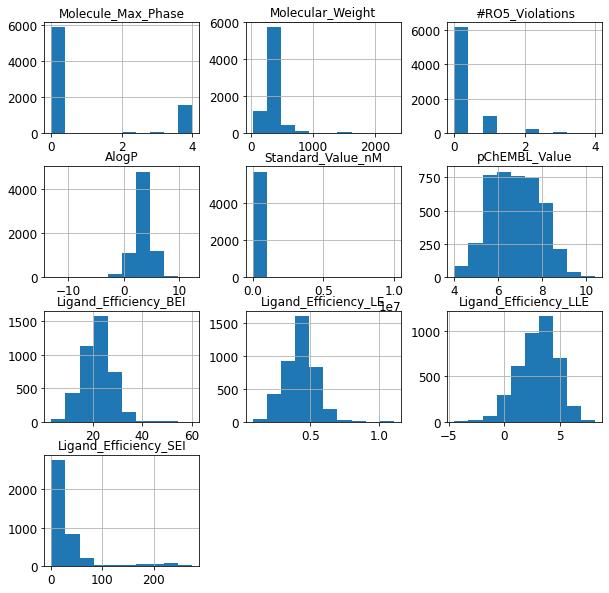

In [26]:
chembl[numeric_cols].hist(figsize=(10,10));

- **Note that pChembl value is better normalized than standard value**
- **Recall that there are lots of different activity types/assays represented in the value columns. Let's split those up:**

Standard_Type,% Ctrl,% Inhibition of Control Specific Binding (Mean n=2),Activity,Affinity,Bmax,Drug uptake,EC50,Efficacy,FC,IC50,INH,Inhibition,Kd,Ki,Km,Ratio,Ratio IC50,Vmax,logEC50
count,8.000000,8.000000,75.000000,1.0,1.000,1.00,3.500000e+01,2.000000,24.000000,2094.000000,14.000000,686.000000,23.000000,1.789000e+03,1.000000,38.000000,7.0,1.000000,2.00000
mean,84.062500,9.762500,429.028000,6.0,22.145,0.95,1.228584e+05,96.550000,1.131667,7040.295955,59842.857143,39.834228,5674.500435,4.716033e+04,1096.666667,15.652895,7.0,0.504333,-7.86300
std,20.612821,13.688049,1459.372669,NaN,NaN,NaN,7.095010e+05,0.919239,0.474238,41499.097395,31604.885559,29.804494,12652.730270,5.245278e+05,NaN,76.562658,0.0,NaN,1.59099
min,39.000000,-14.500000,2.000000,6.0,22.145,0.95,7.100000e+00,95.900000,-0.050000,0.000000,0.000000,-67.000000,0.830000,0.000000e+00,1096.666667,0.050000,7.0,0.504333,-8.98800
25%,79.500000,0.200000,15.000000,6.0,22.145,0.95,7.400000e+01,96.225000,1.122500,32.000000,36700.000000,15.000000,41.000000,3.180000e+01,1096.666667,0.955000,7.0,0.504333,-8.42550
50%,91.000000,16.200000,40.000000,6.0,22.145,0.95,8.270000e+02,96.550000,1.290000,300.000000,64000.000000,50.000000,322.350000,2.940000e+02,1096.666667,1.295000,7.0,0.504333,-7.86300
75%,97.375000,18.875000,101.300000,6.0,22.145,0.95,5.267500e+03,96.875000,1.402500,2207.500000,87500.000000,57.000000,2025.000000,2.300000e+03,1096.666667,1.780000,7.0,0.504333,-7.30050
max,102.000000,23.500000,10000.000000,6.0,22.145,0.95,4.200245e+06,97.200000,1.630000,1000000.000000,94000.000000,100.000000,47900.000000,1.000000e+07,1096.666667,474.000000,7.0,0.504333,-6.73800


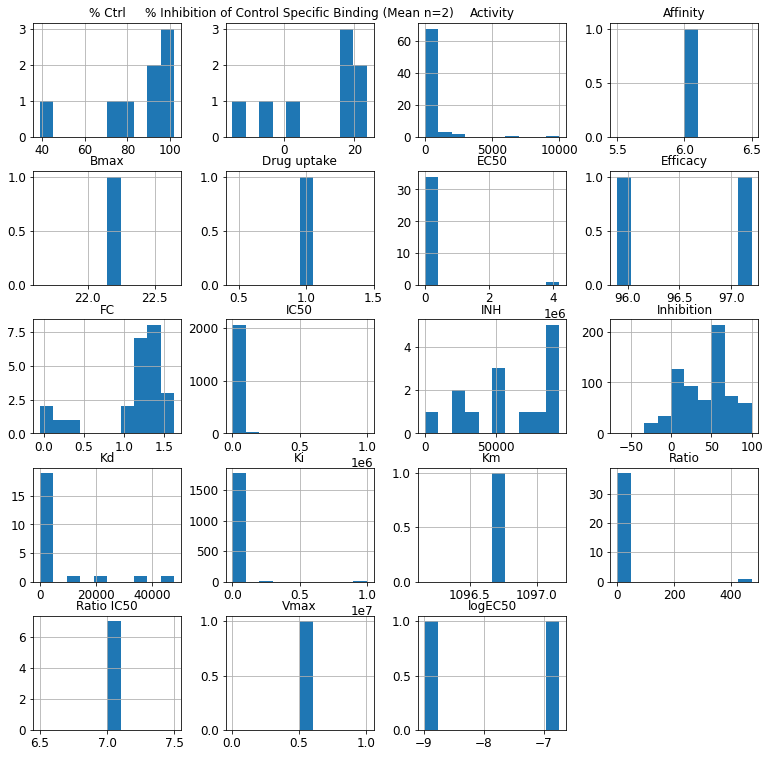

In [27]:
# examine standard values and pChembl values PER standard type
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', columns = 'Standard_Type', values='Standard_Value_nM', aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(13,13));

 What do you notice about the standard values?

Standard_Type,EC50,IC50,Kd,Ki
count,34.000000,1906.000000,23.000000,1586.000000
mean,6.545000,6.711561,6.577246,6.768858
std,0.803565,1.112561,1.356497,1.085380
min,4.460000,4.050000,4.320000,4.010000
25%,6.002500,5.832500,5.700000,5.912500
50%,6.425000,6.675000,6.620000,6.755000
75%,7.162500,7.570000,7.390000,7.600000
max,8.150000,10.430000,9.080000,10.100000


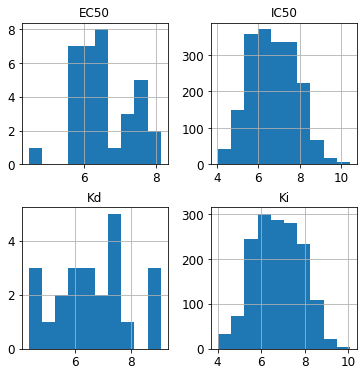

In [28]:
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', columns = 'Standard_Type', values='pChEMBL_Value', aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(6,6));

- **What do you notice about the pChEMBL values?**

## Exercise: explore DTC and Excape data the same way
- **Curation step:** add pValue column from raw measurements if it doesn't exist

DTC

In [29]:
# try it yourself here
dtc = dtc.replace('None',np.nan)
dtc.head()

,Compound_ID,Uniprot_ID,Compound_Name,Standard_inchi_key,Max_Phase,Target_Pref_Name,Gene_Names,Target_Class,Wild_type_or_mutant,Mutation_information,PubMed_ID,End_Point_Standard_Type,End_Point_Standard_Relation,End_Point_Standard_Value,End_Point_Standard_Units,Endpoint_Mode_of_Action,Assay_Format,Assay_Type,Assay_Sub_Type,Inhibitor_Type,Detection_Technology,Compound_concentration_value,Compound_concentration_value_units,Substrate_type,Substrate_Type_Standard_Relation,Substrate_Type_Standard_Value,Substrate_Type_Standard_Units,Assay_cell_line,Assay_Description,Activity_Comments,Title,Journal,Year,Volume,Issue,Authors,Annotation_Comments,Assay_ID,DTC_Tid,DTC_Activity_ID,DTC_Molregno,Record_ID,DTC_Document_ID
0,CHEMBL10,P23975,SB-203580,CDMGBJANTYXAIV-UHFFFAOYSA-N,0,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDCK,DRUGMATRIX: Norepinephrine Transporter radioli...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774705.0,DTCT0023180,7482013,DTCC00132413,2089752,46191
1,CHEMBL10,P23975,SB-203580,CDMGBJANTYXAIV-UHFFFAOYSA-N,0,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,NaN,KI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDCK,DRUGMATRIX: Norepinephrine Transporter radioli...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774705.0,DTCT0023180,7482014,DTCC00132413,2089752,46191
2,CHEMBL1006,P23975,AMIFOSTINE,JKOQGQFVAUAYPM-UHFFFAOYSA-N,4,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDCK,DRUGMATRIX: Norepinephrine Transporter radioli...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774705.0,DTCT0023180,7290025,DTCC00224760,898282,46191
3,CHEMBL1006,P23975,AMIFOSTINE,JKOQGQFVAUAYPM-UHFFFAOYSA-N,4,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,NaN,KI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDCK,DRUGMATRIX: Norepinephrine Transporter radioli...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774705.0,DTCT0023180,7290026,DTCC00224760,898282,46191
4,CHEMBL1009,P23975,LEVODOPA,WTDRDQBEARUVNC-LURJTMIESA-N,4,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDCK,DRUGMATRIX: Norepinephrine Transporter radioli...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774705.0,DTCT0023180,7423055,DTCC00224903,1351112,46191


In [30]:
dtc.End_Point_Standard_Units.unique()

array([nan, 'NM', '%', 'PMOL', 'PMOL/MIN', 'UG.ML-1'], dtype=object)

In [31]:
dtc.End_Point_Standard_Type.unique()

array(['IC50', 'KI', 'INHIBITION', 'ACTIVITY', 'LOGEC50', 'INH', 'RATIO',
       'BMAX', 'KD', 'EC50', 'EFFICACY', 'KM', 'VMAX', 'DRUG UPTAKE',
       'RATIO IC50', 'AFFINITY', 'FC', '% INHIBITION'], dtype=object)

In [32]:
dtc['pDTC_Value'] = np.where(dtc.End_Point_Standard_Units == 'NM',
                            -np.log10(dtc.End_Point_Standard_Value/1000000000),
                            dtc.End_Point_Standard_Value)

dtc['pDTC_Value'] = np.where(dtc.End_Point_Standard_Units == 'PMOL',
                            -np.log10(dtc.End_Point_Standard_Value*0.001),
                            dtc.End_Point_Standard_Value)

In [33]:
dtc.describe()

,Max_Phase,Wild_type_or_mutant,Mutation_information,PubMed_ID,End_Point_Standard_Value,Assay_Sub_Type,Inhibitor_Type,Detection_Technology,Compound_concentration_value,Substrate_type,Substrate_Type_Standard_Relation,Substrate_Type_Standard_Value,Substrate_Type_Standard_Units,Year,Volume,Issue,Annotation_Comments,Assay_ID,DTC_Activity_ID,Record_ID,DTC_Document_ID,pDTC_Value
count,6998.000000,0.0,0.0,4.967000e+03,5.271000e+03,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5061.000000,4828.000000,4757.000000,0.0,6.804000e+03,6.998000e+03,6.998000e+03,6998.000000,5.271000e+03
mean,0.905402,NaN,NaN,1.903177e+07,1.982619e+04,NaN,NaN,NaN,10000.0,NaN,NaN,NaN,NaN,2008.998814,30.312966,13.952281,NaN,6.976838e+05,5.695961e+06,1.075896e+06,39747.014861,1.982617e+04
std,1.643754,NaN,NaN,3.792810e+06,3.306201e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.761465,19.203155,87.030214,NaN,3.274724e+05,4.163082e+06,6.207406e+05,14506.499764,3.306201e+05
min,0.000000,NaN,NaN,7.518514e+06,-6.700000e+01,NaN,NaN,NaN,10000.0,NaN,NaN,NaN,NaN,1993.000000,2.000000,1.000000,NaN,6.232200e+04,7.610000e+02,3.613000e+03,2969.000000,-6.700000e+01
25%,0.000000,NaN,NaN,1.722886e+07,2.100000e+01,NaN,NaN,NaN,10000.0,NaN,NaN,NaN,NaN,2007.000000,18.000000,6.000000,NaN,4.875170e+05,2.374239e+06,5.318610e+05,30478.000000,2.100000e+01
50%,0.000000,NaN,NaN,1.925650e+07,1.100000e+02,NaN,NaN,NaN,10000.0,NaN,NaN,NaN,NaN,2009.000000,21.000000,13.000000,NaN,6.522830e+05,3.395786e+06,1.081354e+06,42462.000000,1.100000e+02
75%,0.000000,NaN,NaN,2.109513e+07,1.300000e+03,NaN,NaN,NaN,10000.0,NaN,NaN,NaN,NaN,2011.000000,49.000000,19.000000,NaN,7.747050e+05,7.421915e+06,1.616115e+06,46191.000000,1.300000e+03
max,4.000000,NaN,NaN,2.813524e+07,1.000000e+07,NaN,NaN,NaN,10000.0,NaN,NaN,NaN,NaN,2016.000000,329.000000,5996.000000,NaN,1.586715e+06,1.481912e+07,2.111389e+06,69826.000000,1.000000e+07


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4bdbcb7d50>,
      dtype=object)

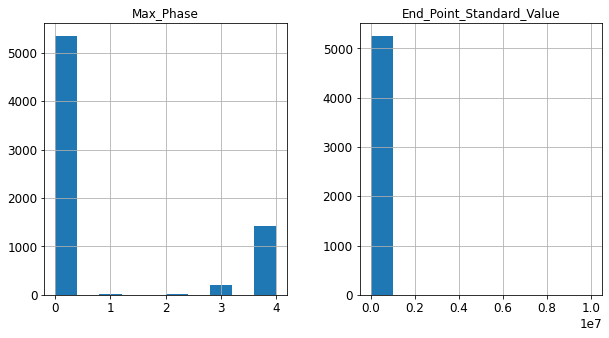

In [34]:
numeric_cols = ['Max_Phase','End_Point_Standard_Value']
dtc[numeric_cols].hist(figsize = (10,5))

End_Point_Standard_Type,ACTIVITY,AFFINITY,BMAX,EC50,EFFICACY,FC,IC50,INH,INHIBITION,KD,KI,KM,LOGEC50,RATIO,RATIO IC50,VMAX
count,62.000000,1.0,1.0,15.000000,2.000000,24.000000,1876.000000,14.000000,464.000000,22.000000,1.773000e+03,1.0,2.00000,38.000000,7.0,1.00
mean,420.501613,6.0,129.5,2654.724667,96.550000,1.131667,3289.551141,59842.857143,44.062263,5916.102727,4.754097e+04,690.0,-7.86500,15.652895,7.0,1.78
std,1570.466614,NaN,NaN,8876.031118,0.919239,0.474238,25482.095508,31604.885559,27.980070,12896.109013,5.268198e+05,NaN,1.59099,76.562658,0.0,NaN
min,2.000000,6.0,129.5,7.100000,95.900000,-0.050000,0.000000,0.000000,-67.000000,0.830000,2.210000e-01,690.0,-8.99000,0.050000,7.0,1.78
25%,14.000000,6.0,129.5,28.000000,96.225000,1.122500,27.887500,36700.000000,19.950000,32.425000,3.700000e+01,690.0,-8.42750,0.955000,7.0,1.78
50%,34.000000,6.0,129.5,83.000000,96.550000,1.290000,204.585000,64000.000000,50.000000,300.000000,3.300000e+02,690.0,-7.86500,1.295000,7.0,1.78
75%,52.250000,6.0,129.5,679.000000,96.875000,1.402500,1470.000000,87500.000000,62.000000,2137.500000,2.530000e+03,690.0,-7.30250,1.780000,7.0,1.78
max,10000.000000,6.0,129.5,34673.690000,97.200000,1.630000,1000000.000000,94000.000000,100.000000,47900.000000,1.000000e+07,690.0,-6.74000,474.000000,7.0,1.78


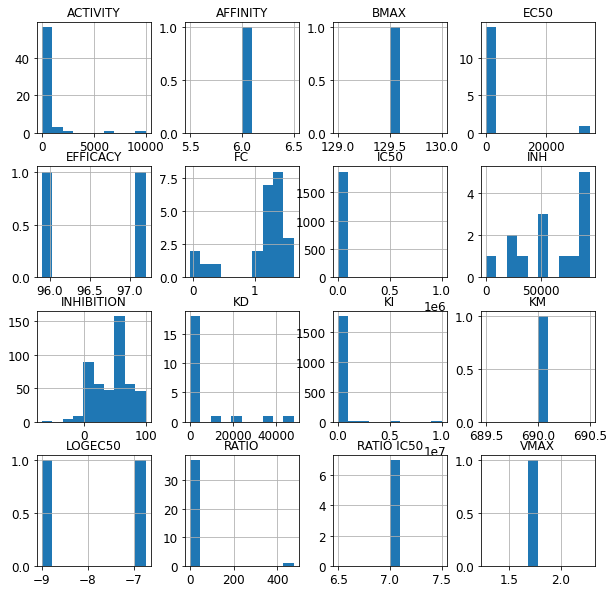

In [35]:
dtc_types=dtc.pivot_table(index = 'Compound_ID', columns = 'End_Point_Standard_Type', values='End_Point_Standard_Value', aggfunc='mean')
display(dtc_types.describe())
dtc_types.hist(figsize=(10,10));

In [36]:
#dtc_types=dtc.pivot_table(index = 'Compound_ID', columns = 'End_Point_Standard_Type', values='pDTC_Value', aggfunc='mean')
#display(dtc_types.describe())
#dtc_types.hist(figsize=(10,10));

Excape

In [37]:
excape = excape.replace('None',np.nan)
excape.head()

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES
0,CTETYYAZBPJBHE-UHFFFAOYNA-N,CHEMBL1289,6530,A,5.56000,chembl20,774705,9606,SLC6A2,4059,C(#CI)COC=1C=C(Cl)C(=CC1Cl)Cl
1,QVLGCILLMAUJBI-UHFFFAOYNA-N,16494915,6530,A,5.00056,pubchem,578387,9606,SLC6A2,4059,S1C(C2(CCCCC2)CN)=CC=C1
2,NTDQQZYCCIDJRK-UHFFFAOYNA-N,CHEMBL195437,6530,N,4.21000,chembl20,774705,9606,SLC6A2,4059,C=1(C=CC(=CC1)CCCCCCCC)O
3,OLBCVFGFOZPWHH-UHFFFAOYNA-N,CHEMBL526,6530,A,5.03000,chembl20,774705,9606,SLC6A2,4059,OC=1C(=CC=CC1C(C)C)C(C)C
4,NGBBVGZWCFBOGO-UHFFFAOYNA-N,CHEMBL6731,6530,A,6.58000,chembl20,639476,9606,SLC6A2,4059,O1C2=C(OC1)C=CC(=C2)CC(N)C


,Entrez_ID,pXC50,Original_Assay_ID,Tax_ID,Ortholog_Group
count,2776.0,2775.000000,2.776000e+03,2776.0,2776.0
mean,6530.0,6.770690,5.096714e+05,9606.0,4059.0
std,0.0,1.192243,2.000465e+05,0.0,0.0
min,6530.0,2.260000,1.408810e+05,9606.0,4059.0
25%,6530.0,5.890000,3.620250e+05,9606.0,4059.0
50%,6530.0,6.810000,4.875170e+05,9606.0,4059.0
75%,6530.0,7.660000,6.343270e+05,9606.0,4059.0
max,6530.0,11.520000,1.365256e+06,9606.0,4059.0


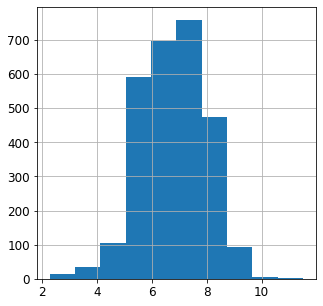

In [38]:
display(excape.describe())
excape.pXC50.hist(figsize=(5,5))

## EDA & Exercise: compare pResponse values across all three datasets
- create a histogram or kde plot with legend showing distributions for all three datasets on the same plot

## Exercise: analyze & discuss
- what value types you would model and why?
- how would you use this data for a classification model?
- do any of the three datasets include a column you could use for classification?

# EDA: Compounds
- make sure smiles strings exist since that's what AMPL uses
- compare compounds in each dataset
- featurize with ECFP fingerprints
- examine diversity of compound set

## **Curation step** & exercise: Get SMILES for DTC data from chemical identifiers
Since AMPL and other modeling pipelines use SMILES strings, we will use these as our primary data curation tool.
1. open DTC file in google sheets/excel or from the LHS folder menu, right-click on the "HTR3A_DTC.csv" file to download it to your computer and open the file with Excel. 
2. copy/paste the compound ID (ChEMBLXXXXXXX) column into pubchem ID exchange service: https://pubchem.ncbi.nlm.nih.gov/idexchange/idexchange.cgi  (use highlight and click on "Follow-link" option to open the link in your browser)
  - did you get the whole column??
  - Be sure to select the correct registry ID for the input id list
  - Select "Same CID" and SMILES as output

6. upload resulting text file into Columbia_E4511 folder

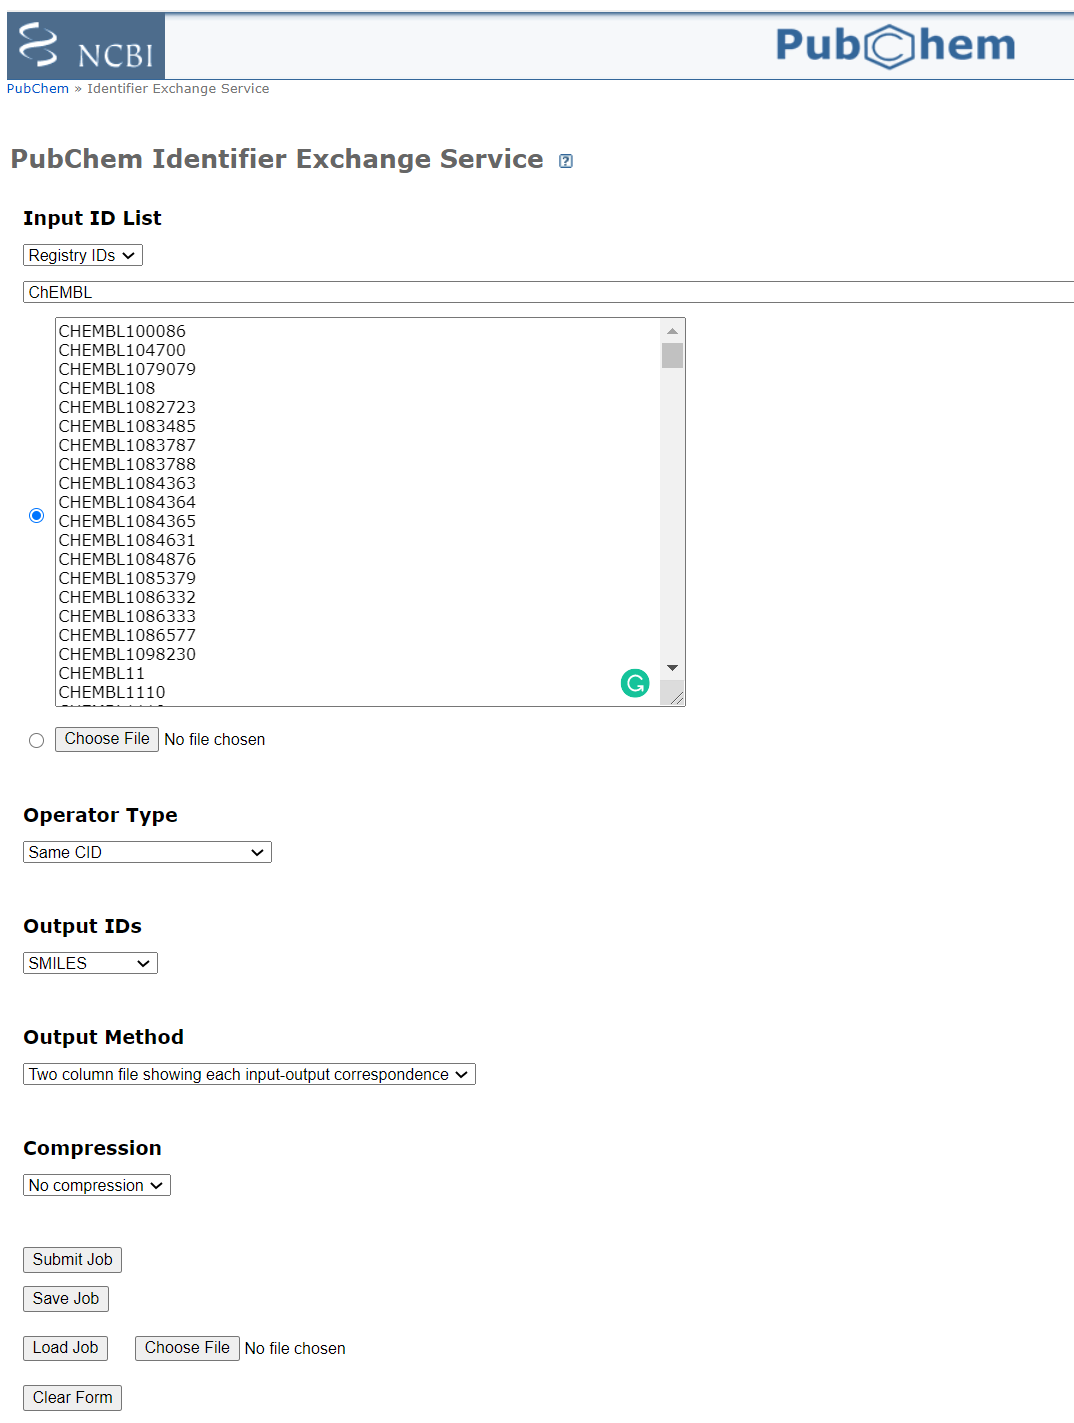

In [39]:
from IPython.display import Image
Image("https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/Img/PubChemCIDExchange.png", 
      width = 900, height = 900)

## Note, the output from PubChem Identifier Exchange Service can be uploaded into the left hand window of COLAB by dragging and dropping the file. In my case the output file is, `3897649727682520004.txt`

In my case, I have saved the file in Github and I am uploading it. 

In [40]:
! wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/A-HTR3A/3897649727682520004.txt

--2021-03-18 20:25:25--  https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/A-HTR3A/3897649727682520004.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90865 (89K) [text/plain]
Saving to: ‘3897649727682520004.txt’

3897649727682520004 100%[===================>]  88.74K  --.-KB/s    in 0.002s  

2021-03-18 20:25:25 (47.1 MB/s) - ‘3897649727682520004.txt’ saved [90865/90865]



In [41]:
# open file from pubchem ID exchange service
dtc_smiles = pd.read_csv("3897649727682520004.txt", sep="\t", header=None)
dtc_smiles=dtc_smiles.rename(columns = {0:'ChEMBL_ID',1:'SMILES'})
dtc_smiles.head()

,ChEMBL_ID,SMILES
0,CHEMBL100086,COC1=CC=CC(=C1)CN2CCN(CC2)C3CCC(CC3)(C4=CC5=C(...
1,CHEMBL104700,C1CC2CCC1N2CC3=CN=CC=C3
2,CHEMBL1079079,COC1=CC=C(C=C1)C2=C(C(=NN2C3=CC=CC=C3[125I])C(...
3,CHEMBL108,C1=CC=C2C(=C1)C=CC3=CC=CC=C3N2C(=O)N
4,CHEMBL1082723,C[C@H]1CC2=C([C@]3(N1)C4=C(C=CC(=C4)Cl)NC3=O)N...


In [42]:
dtc_smiles['ChEMBL_ID']

0        CHEMBL100086
1        CHEMBL104700
2       CHEMBL1079079
3           CHEMBL108
4       CHEMBL1082723
            ...      
1276      CHEMBL93919
1277         CHEMBL96
1278      CHEMBL98883
1279      CHEMBL98883
1280      CHEMBL98883
Name: ChEMBL_ID, Length: 1281, dtype: object

In [43]:
# map chembl id to smiles using a dict
dtc['SMILES'] = dtc['Compound_ID'].map(dict(zip(dtc_smiles.ChEMBL_ID, dtc_smiles.SMILES)))

In [44]:
# what's missing?
print("No ChemblID in DTC:", len(dtc[dtc['Compound_ID'].isna()]))
print("No SMILES from ChemblID in DTC:", len(dtc[dtc.SMILES.isna()]))

No ChemblID in DTC: 18
No SMILES from ChemblID in DTC: 6596


## Exercise: try to recover the missing smiles from other chemical identifiers in the DTC file.

In [45]:
# try it yourself here

## EDA: Examine compound overlaps
Start with questions you have about the compounds at this point in time, such as:
- what compounds are in each set? do they overlap?
- are the compounds diverse or all very similar to each other?

In [46]:
from matplotlib_venn import venn3
from matplotlib_venn import venn2

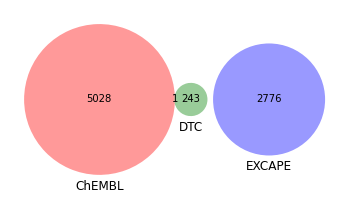

In [47]:
# overlaps from SMILES strings
venn3([set(chembl.Smiles),
           set(dtc.SMILES),
           set(excape.SMILES)],
          set_labels = ['ChEMBL', 'DTC','EXCAPE']);

# venn diagram for overlapping ChEMBL IDs - mpv requires sets not lists

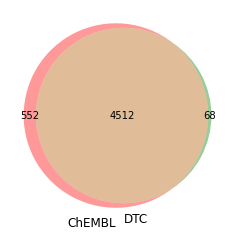

In [48]:
venn2([set(chembl.Molecule_ChEMBL_ID), set(dtc.Compound_ID)], set_labels=['ChEMBL','DTC']);

The chembl IDs overlap, why not the smiles strings? One explanation is that each database's SMILES string representations are slightly different. Answer? **STANDARDIZE the smiles strings.**

## **Curation step:** Standardize smiles strings, drop rows without base smiles

Chembl

In [49]:
chembl['base_rdkit_smiles'] = chembl.Smiles.apply(curate_data.base_smiles_from_smiles)
print(len(chembl.Smiles))
print(len(chembl.Smiles.unique()))
print(len(chembl.base_rdkit_smiles.unique()))

7603
5029
4989


In [50]:
chembl[chembl.base_rdkit_smiles=='']

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM,base_rdkit_smiles
461,CHEMBL1909055,COBALTOUS CHLORIDE,4.0,129.84,NaN,NaN,COBALT (II) CHLORIDE,NaN,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909094,DRUGMATRIX: Norepinephrine Transporter radioli...,B,BAO_0000249,cell membrane format,NaN,NaN,NaN,MDCK,Membrane,NaN,NaN,NaN,CHEMBL222,Norepinephrine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3308370,NaN,NaN,
482,CHEMBL1201631,INSULIN,4.0,NaN,NaN,NaN,INSULIN,NaN,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909094,DRUGMATRIX: Norepinephrine Transporter radioli...,B,BAO_0000249,cell membrane format,NaN,NaN,NaN,MDCK,Membrane,NaN,NaN,NaN,CHEMBL222,Norepinephrine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3308370,NaN,NaN,
499,CHEMBL1200693,MANGANESE CHLORIDE,4.0,125.84,NaN,NaN,MANGANESE (II) CHLORIDE,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909094,DRUGMATRIX: Norepinephrine Transporter radioli...,B,BAO_0000249,cell membrane format,NaN,NaN,NaN,MDCK,Membrane,NaN,NaN,NaN,CHEMBL222,Norepinephrine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3308370,NaN,NaN,
562,CHEMBL324631,PIPERIDINE BASED ANALOGUE OF COCAINE (STRUCTUR...,0.0,643.29,NaN,NaN,8a,NaN,Ki,'=',392.6,nM,6.41,NaN,NaN,UO_0000065,9.96,NaN,NaN,NaN,False,CHEMBL744179,Norepinephrine transporter activity was determ...,B,BAO_0000357,single protein format,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL222,Norepinephrine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1131881,1,Scientific Literature,Bioorg. Med. Chem. Lett.,1999.0,NaN,NaN,392.6,
597,CHEMBL1909067,NaN,0.0,NaN,NaN,NaN,MC 258714,NaN,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909094,DRUGMATRIX: Norepinephrine Transporter radioli...,B,BAO_0000249,cell membrane format,NaN,NaN,NaN,MDCK,Membrane,NaN,NaN,NaN,CHEMBL222,Norepinephrine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3308370,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6784,CHEMBL11359,CISPLATIN,4.0,300.05,NaN,NaN,CISPLATIN,NaN,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909094,DRUGMATRIX: Norepinephrine Transporter radioli...,B,BAO_0000249,cell membrane format,NaN,NaN,NaN,MDCK,Membrane,NaN,NaN,NaN,CHEMBL222,Norepinephrine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3308370,NaN,NaN,
6956,CHEMBL1909083,ZIRCONIUM(IV) CHLORIDE,0.0,233.04,NaN,NaN,ZIRCONIUM(IV) CHLORIDE,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909094,DRUGMATRIX: Norepinephrine Transporter radioli...,B,BAO_0000249,cell membrane format,NaN,NaN,NaN,MDCK,Membrane,NaN,NaN,NaN,CHEMBL222,Norepinephrine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3308370,NaN,NaN,
6987,CHEMBL1909054,CARBO

In [51]:
chembl=chembl.replace('',np.nan)
chembl[chembl.base_rdkit_smiles.isna()]

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM,base_rdkit_smiles
461,CHEMBL1909055,COBALTOUS CHLORIDE,4.0,129.84,NaN,NaN,COBALT (II) CHLORIDE,NaN,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909094,DRUGMATRIX: Norepinephrine Transporter radioli...,B,BAO_0000249,cell membrane format,NaN,NaN,NaN,MDCK,Membrane,NaN,NaN,NaN,CHEMBL222,Norepinephrine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3308370,NaN,NaN,NaN
482,CHEMBL1201631,INSULIN,4.0,NaN,NaN,NaN,INSULIN,NaN,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909094,DRUGMATRIX: Norepinephrine Transporter radioli...,B,BAO_0000249,cell membrane format,NaN,NaN,NaN,MDCK,Membrane,NaN,NaN,NaN,CHEMBL222,Norepinephrine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3308370,NaN,NaN,NaN
499,CHEMBL1200693,MANGANESE CHLORIDE,4.0,125.84,NaN,NaN,MANGANESE (II) CHLORIDE,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909094,DRUGMATRIX: Norepinephrine Transporter radioli...,B,BAO_0000249,cell membrane format,NaN,NaN,NaN,MDCK,Membrane,NaN,NaN,NaN,CHEMBL222,Norepinephrine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3308370,NaN,NaN,NaN
562,CHEMBL324631,PIPERIDINE BASED ANALOGUE OF COCAINE (STRUCTUR...,0.0,643.29,NaN,NaN,8a,NaN,Ki,'=',392.6,nM,6.41,NaN,NaN,UO_0000065,9.96,NaN,NaN,NaN,False,CHEMBL744179,Norepinephrine transporter activity was determ...,B,BAO_0000357,single protein format,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL222,Norepinephrine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1131881,1,Scientific Literature,Bioorg. Med. Chem. Lett.,1999.0,NaN,NaN,392.6,NaN
597,CHEMBL1909067,NaN,0.0,NaN,NaN,NaN,MC 258714,NaN,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909094,DRUGMATRIX: Norepinephrine Transporter radioli...,B,BAO_0000249,cell membrane format,NaN,NaN,NaN,MDCK,Membrane,NaN,NaN,NaN,CHEMBL222,Norepinephrine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3308370,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6784,CHEMBL11359,CISPLATIN,4.0,300.05,NaN,NaN,CISPLATIN,NaN,Ki,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909094,DRUGMATRIX: Norepinephrine Transporter radioli...,B,BAO_0000249,cell membrane format,NaN,NaN,NaN,MDCK,Membrane,NaN,NaN,NaN,CHEMBL222,Norepinephrine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3308370,NaN,NaN,NaN
6956,CHEMBL1909083,ZIRCONIUM(IV) CHLORIDE,0.0,233.04,NaN,NaN,ZIRCONIUM(IV) CHLORIDE,NaN,IC50,NaN,NaN,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,False,CHEMBL1909094,DRUGMATRIX: Norepinephrine Transporter radioli...,B,BAO_0000249,cell membrane format,NaN,NaN,NaN,MDCK,Membrane,NaN,NaN,NaN,CHEMBL222,Norepinephrine transporter,Homo sapiens,SINGLE PROTEIN,CHEMBL1909046,15,DrugMatrix,NaN,NaN,CHEMBL3308370,NaN,NaN,NaN
698

In [52]:
chembl=chembl[~chembl.base_rdkit_smiles.isna()]

## Exercise: standardize other datasets
- what do you notice about the number of unique smiles strings before and after standardization?
- what does this mean for the nature of the compounds in a given dataset?
- hint: look at chemical identifiers that have the same base_rdkit_smiles, and the 'DB' column in excape

In [53]:
dtc['base_rdkit_smiles'] = dtc.SMILES.apply(curate_data.base_smiles_from_smiles)
print(len(dtc.SMILES))
print(len(dtc.SMILES.unique()))

6998
244


In [54]:
dtc[dtc.base_rdkit_smiles=='']

,Compound_ID,Uniprot_ID,Compound_Name,Standard_inchi_key,Max_Phase,Target_Pref_Name,Gene_Names,Target_Class,Wild_type_or_mutant,Mutation_information,PubMed_ID,End_Point_Standard_Type,End_Point_Standard_Relation,End_Point_Standard_Value,End_Point_Standard_Units,Endpoint_Mode_of_Action,Assay_Format,Assay_Type,Assay_Sub_Type,Inhibitor_Type,Detection_Technology,Compound_concentration_value,Compound_concentration_value_units,Substrate_type,Substrate_Type_Standard_Relation,Substrate_Type_Standard_Value,Substrate_Type_Standard_Units,Assay_cell_line,Assay_Description,Activity_Comments,Title,Journal,Year,Volume,Issue,Authors,Annotation_Comments,Assay_ID,DTC_Tid,DTC_Activity_ID,DTC_Molregno,Record_ID,DTC_Document_ID,pDTC_Value,SMILES,base_rdkit_smiles
0,CHEMBL10,P23975,SB-203580,CDMGBJANTYXAIV-UHFFFAOYSA-N,0,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDCK,DRUGMATRIX: Norepinephrine Transporter radioli...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774705.0,DTCT0023180,7482013,DTCC00132413,2089752,46191,NaN,NaN,
1,CHEMBL10,P23975,SB-203580,CDMGBJANTYXAIV-UHFFFAOYSA-N,0,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,NaN,KI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDCK,DRUGMATRIX: Norepinephrine Transporter radioli...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774705.0,DTCT0023180,7482014,DTCC00132413,2089752,46191,NaN,NaN,
2,CHEMBL1006,P23975,AMIFOSTINE,JKOQGQFVAUAYPM-UHFFFAOYSA-N,4,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDCK,DRUGMATRIX: Norepinephrine Transporter radioli...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774705.0,DTCT0023180,7290025,DTCC00224760,898282,46191,NaN,NaN,
3,CHEMBL1006,P23975,AMIFOSTINE,JKOQGQFVAUAYPM-UHFFFAOYSA-N,4,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,NaN,KI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDCK,DRUGMATRIX: Norepinephrine Transporter radioli...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774705.0,DTCT0023180,7290026,DTCC00224760,898282,46191,NaN,NaN,
4,CHEMBL1009,P23975,LEVODOPA,WTDRDQBEARUVNC-LURJTMIESA-N,4,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDCK,DRUGMATRIX: Norepinephrine Transporter radioli...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774705.0,DTCT0023180,7423055,DTCC00224903,1351112,46191,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6993,NaN,P23975,HYDROXYNEFAZODONE,PPJRQXMDFSRWFH-UHFFFAOYSA-N,0,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,9400006.0,KI,=,1053.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DTCT0023180,14753147,DTCC01745959,2107663,68466,1053.0,NaN,
6994,NaN,P23975,MDL 100907,HXTGXYRHXAGCFP-UHFFFAOYSA-N,0,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,15999145.0,KI,=,10000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DTCT0023180,14750504,DTCC01745097,2109914,69464,10000.0,NaN,
6995,NaN,P23975,S33005,UBIQMAFTTDZGEX-UHFFFAOYSA-N,0,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,11454918.0,KI,=,1510.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [55]:
dtc=dtc.replace('',np.nan)
dtc[dtc.base_rdkit_smiles.isna()]

,Compound_ID,Uniprot_ID,Compound_Name,Standard_inchi_key,Max_Phase,Target_Pref_Name,Gene_Names,Target_Class,Wild_type_or_mutant,Mutation_information,PubMed_ID,End_Point_Standard_Type,End_Point_Standard_Relation,End_Point_Standard_Value,End_Point_Standard_Units,Endpoint_Mode_of_Action,Assay_Format,Assay_Type,Assay_Sub_Type,Inhibitor_Type,Detection_Technology,Compound_concentration_value,Compound_concentration_value_units,Substrate_type,Substrate_Type_Standard_Relation,Substrate_Type_Standard_Value,Substrate_Type_Standard_Units,Assay_cell_line,Assay_Description,Activity_Comments,Title,Journal,Year,Volume,Issue,Authors,Annotation_Comments,Assay_ID,DTC_Tid,DTC_Activity_ID,DTC_Molregno,Record_ID,DTC_Document_ID,pDTC_Value,SMILES,base_rdkit_smiles
0,CHEMBL10,P23975,SB-203580,CDMGBJANTYXAIV-UHFFFAOYSA-N,0,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDCK,DRUGMATRIX: Norepinephrine Transporter radioli...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774705.0,DTCT0023180,7482013,DTCC00132413,2089752,46191,NaN,NaN,NaN
1,CHEMBL10,P23975,SB-203580,CDMGBJANTYXAIV-UHFFFAOYSA-N,0,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,NaN,KI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDCK,DRUGMATRIX: Norepinephrine Transporter radioli...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774705.0,DTCT0023180,7482014,DTCC00132413,2089752,46191,NaN,NaN,NaN
2,CHEMBL1006,P23975,AMIFOSTINE,JKOQGQFVAUAYPM-UHFFFAOYSA-N,4,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDCK,DRUGMATRIX: Norepinephrine Transporter radioli...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774705.0,DTCT0023180,7290025,DTCC00224760,898282,46191,NaN,NaN,NaN
3,CHEMBL1006,P23975,AMIFOSTINE,JKOQGQFVAUAYPM-UHFFFAOYSA-N,4,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,NaN,KI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDCK,DRUGMATRIX: Norepinephrine Transporter radioli...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774705.0,DTCT0023180,7290026,DTCC00224760,898282,46191,NaN,NaN,NaN
4,CHEMBL1009,P23975,LEVODOPA,WTDRDQBEARUVNC-LURJTMIESA-N,4,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDCK,DRUGMATRIX: Norepinephrine Transporter radioli...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774705.0,DTCT0023180,7423055,DTCC00224903,1351112,46191,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6993,NaN,P23975,HYDROXYNEFAZODONE,PPJRQXMDFSRWFH-UHFFFAOYSA-N,0,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,9400006.0,KI,=,1053.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DTCT0023180,14753147,DTCC01745959,2107663,68466,1053.0,NaN,NaN
6994,NaN,P23975,MDL 100907,HXTGXYRHXAGCFP-UHFFFAOYSA-N,0,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,15999145.0,KI,=,10000.0,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DTCT0023180,14750504,DTCC01745097,2109914,69464,10000.0,NaN,NaN
6995,NaN,P23975,S33005,UBIQMAFTTDZGEX-UHFFFAOYSA-N,0,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,11454918.0,KI,=,1510.0,NM,NaN,NaN,NaN,Na

In [56]:
dtc[dtc.base_rdkit_smiles.duplicated(keep=False)].sort_values('base_rdkit_smiles')

,Compound_ID,Uniprot_ID,Compound_Name,Standard_inchi_key,Max_Phase,Target_Pref_Name,Gene_Names,Target_Class,Wild_type_or_mutant,Mutation_information,PubMed_ID,End_Point_Standard_Type,End_Point_Standard_Relation,End_Point_Standard_Value,End_Point_Standard_Units,Endpoint_Mode_of_Action,Assay_Format,Assay_Type,Assay_Sub_Type,Inhibitor_Type,Detection_Technology,Compound_concentration_value,Compound_concentration_value_units,Substrate_type,Substrate_Type_Standard_Relation,Substrate_Type_Standard_Value,Substrate_Type_Standard_Units,Assay_cell_line,Assay_Description,Activity_Comments,Title,Journal,Year,Volume,Issue,Authors,Annotation_Comments,Assay_ID,DTC_Tid,DTC_Activity_ID,DTC_Molregno,Record_ID,DTC_Document_ID,pDTC_Value,SMILES,base_rdkit_smiles
2757,CHEMBL2391541,P23975,NaN,HGRHWEAUHXYNNP-UHFFFAOYSA-N,0,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,23602445.0,KI,=,12008.00,NM,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HEK293,Inhibition of [3H]norepinephrine uptake at hum...,NaN,An analysis of the synthetic tryptamines AMT a...,Bioorg. Med. Chem. Lett.,2013.0,23.0,11.0,"Arunotayanun W, Dalley JW, Huang XP, Setola V,...",NaN,965140.0,DTCT0023180,12465477,DTCC01379235,1386484,54821,12008.00,COC1=CC2=C(C=C1)NC=C2CCN(CC=C)CC=C,C=CCN(CC=C)CCc1c[nH]c2ccc(OC)cc12
2759,CHEMBL2391541,P23975,NaN,HGRHWEAUHXYNNP-UHFFFAOYSA-N,0,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,26739781.0,KI,<,10000.00,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Binding affinity to NET (unknown origin) by co...,NaN,Receptor binding profiles and quantitative str...,Bioorg. Med. Chem. Lett.,2016.0,26.0,3.0,"Cozzi NV, Daley PF.",NaN,1550158.0,DTCT0023180,62501,DTCC01379235,1369782,65871,10000.00,COC1=CC2=C(C=C1)NC=C2CCN(CC=C)CC=C,C=CCN(CC=C)CCc1c[nH]c2ccc(OC)cc12
2758,CHEMBL2391541,P23975,NaN,HGRHWEAUHXYNNP-UHFFFAOYSA-N,0,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,23602445.0,KI,>,10000.00,NM,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HEK293,Displacement of [3H]Nisoxetine from human reco...,NaN,An analysis of the synthetic tryptamines AMT a...,Bioorg. Med. Chem. Lett.,2013.0,23.0,11.0,"Arunotayanun W, Dalley JW, Huang XP, Setola V,...",NaN,964941.0,DTCT0023180,12464697,DTCC01379235,1386484,54821,10000.00,COC1=CC2=C(C=C1)NC=C2CCN(CC=C)CC=C,C=CCN(CC=C)CCc1c[nH]c2ccc(OC)cc12
2756,CHEMBL2391541,P23975,NaN,HGRHWEAUHXYNNP-UHFFFAOYSA-N,0,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,23602445.0,IC50,=,42657.95,NM,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HEK293,Inhibition of [3H]norepinephrine uptake at hum...,NaN,An analysis of the synthetic tryptamines AMT a...,Bioorg. Med. Chem. Lett.,2013.0,23.0,11.0,"Arunotayanun W, Dalley JW, Huang XP, Setola V,...",NaN,965140.0,DTCT0023180,12465478,DTCC01379235,1386484,54821,42657.95,COC1=CC2=C(C=C1)NC=C2CCN(CC=C)CC=C,C=CCN(CC=C)CCc1c[nH]c2ccc(OC)cc12
5474,CHEMBL500,P23975,PINDOLOL,JZQKKSLKJUAGIC-UHFFFAOYSA-N,4,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,NaN,KI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MDCK,DRUGMATRIX: Norepinephrine Transporter radioli...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774705.0,DTCT0023180,7385198,DTCC00139321,736265,46191,NaN,CC(C)NCC(COC1=CC=CC2=C1C=CN2)O,CC(C)NCC(O)COc1cccc2[nH]ccc12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6993,NaN,P23975,HYDROXYNEFAZODONE,PPJRQXMDFSRWFH-UHFFFAOYSA-N,0,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,9400006.0,KI,=,1053.00,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DTCT0023180,14753147,DTCC01745959,2107663,68466,1053.00,NaN,NaN
6994,NaN,P23975,MDL 100907,HXTGXYRHXAGCFP-UHFFFAOYSA-N,0,NOREPINEPHRINE TRANSPORTER,SLC6A2,Transporter,NaN,NaN,15999145.

In [57]:
excape['base_rdkit_smiles'] = excape.SMILES.apply(curate_data.base_smiles_from_smiles)
print(len(excape.SMILES))
print(len(excape.SMILES.unique()))

2776
2776


## **Curation step:** Save standardized datasets

In [60]:
chembl.to_csv("/content/drive/MyDrive/Columbia_E4511/SLC6A2_ChEMBL_SMILES.csv")
dtc.to_csv("/content/drive/MyDrive/Columbia_E4511/SLC6A2_DTC_SMILES.csv")
excape.to_csv("/content/drive/MyDrive/Columbia_E4511/SLC6A2_Excape_SMILES.csv")

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Exercise: examine compound overlaps from standardized smiles strings
- create venn diagram with 3 circles for all 3 datasets

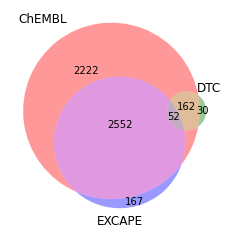

In [61]:
venn3([set(chembl.base_rdkit_smiles),
           set(dtc.base_rdkit_smiles),
           set(excape.base_rdkit_smiles)],
          set_labels = ['ChEMBL', 'DTC','EXCAPE']);

## EDA: Examine compound diversity

In [71]:
#import diversity_plots as dp
sns.set_context('poster')

In [72]:
dp.plot_tani_dist_distr(chembl, 'base_rdkit_smiles', 'ChEMBL Dataset')

AttributeError: ignored

In [73]:
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/SLC6A2_ChEMBL_SMILES.csv', 
                   id_col ='Molecule_ChEMBL_ID', smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, response_col = 'pChEMBL_Value')

Exception: ignored

## Exercise: create plots for DTC, Excape
- What happens when you change the ecfp radius?
- bonus: try creating MCS plots by looking at the documentation of the diversity_plots function
- warning: it is very slow for >1000 ish compounds. 
- extra bonus: select a random subset of 1000 compounds and create the MCS plots.

In [75]:
dp.plot_tani_dist_distr(dtc, 'base_rdkit_smiles', 'dtc Dataset')
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/SLC6A2_DTC_SMILES.csv', 
                   id_col ='Molecule_dtc_ID', smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, response_col = 'pDTC_Value')

AttributeError: ignored

In [74]:
dp.plot_tani_dist_distr(excape, 'base_rdkit_smiles', 'dtc Dataset')
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/SLC6A2_Excape_SMILES.csv', 
                   id_col ='Molecule_excape_ID', smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, response_col = 'pExcape_Value')

AttributeError: ignored

## Exercise: analyze and discuss these plots.
- what are Morgan fingerprints (ecfp)? 
  - what does radius mean?
  - what does a bit in an ECFP vector correspond to?
  - what radius and vector length are used in these functions?
  - hint: look at the .py files for more info
- what is tanimoto distance? What do values closer to zero or closer to one mean?
- do you think your sets of compounds are diverse?
- what do you observe from the 2D projection of compounds?
- are there any similarities between groups of compounds in your datasets?